In [ ]:
from utils.flax_utils import restore_agent
import glob, tqdm, wandb, os, json, random, time, jax
from absl import app, flags
from ml_collections import config_flags
from log_utils import setup_wandb, get_exp_name, get_flag_dict, CsvLogger

from envs.env_utils import make_env_and_datasets
from envs.ogbench_utils import make_ogbench_env_and_datasets
from envs.robomimic_utils import is_robomimic_env

from utils.flax_utils import save_agent
from utils.datasets import Dataset, ReplayBuffer

from evaluation import evaluate
from agents import agents
import numpy as np

import json
import ml_collections

def load_config_from_json(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    # 딕셔너리를 ConfigDict로 변환 (점 표기법 사용 가능 및 Type safety)
    config = ml_collections.ConfigDict(data)
    return config

FLAGS = flags.FLAGS

flags.DEFINE_string('checkpoint_path', '', 'Checkpoint path')
flags.DEFINE_integer('checkpoint_step', 1000000, 'Checkpoint step')

ROBOMIMIC WARNING(
    No private macro file found!
    It is recommended to use a private macro file
    To setup, run: python /home/jellyho/miniconda3/envs/debs/lib/python3.10/site-packages/robomimic/scripts/setup_macros.py
)


In [ ]:


path = '/home/jellyho/Offline/debs/exp2/debs/reproduce/cube-double-play-singletask-task1-v0/sd000s_16863.0.20251130_064522'
flag_config = load_config_from_json(f'{path}/flags.json')
config = flag_config.agent
config["horizon_length"] = flag_config.horizon_length

In [35]:
agent_class = agents['debs']
agent = agent_class.create(
    0,
    example_batch['observations'],
    example_batch['actions'],
    config,
)

In [36]:
agent = restore_agent(agent, path, 1000000)

Restored from /home/jellyho/Offline/debs/exp2/debs/reproduce/cube-double-play-singletask-task1-v0/sd000s_16863.0.20251130_064522/params_1000000.pkl


In [41]:
s['observations'].shape

(10, 4, 37)

In [48]:
s['rewards'].shape

(10, 4)

In [ ]:
next_zs = agent.network.select('critic')(s['next_observations'][-1])
current_zs = agent.network.select('critic')(['observations'][0])

In [49]:
current_zs.shape

(4, 51)

In [45]:
current_zs.shape, next_zs.shape

((4, 51), (4, 51))

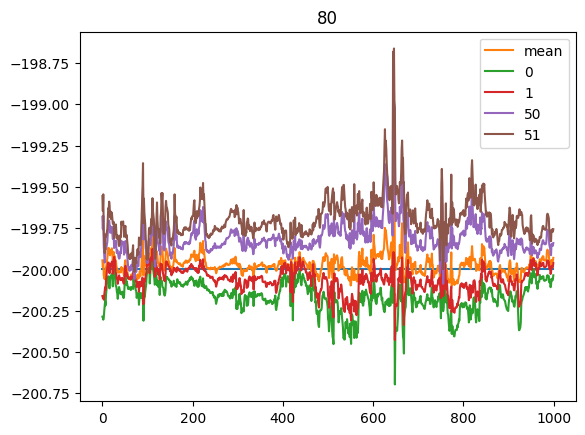

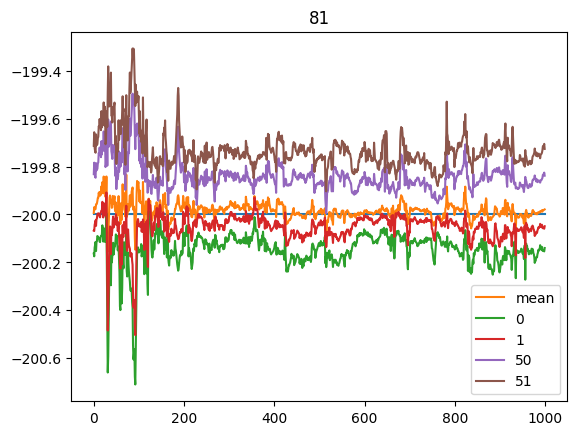

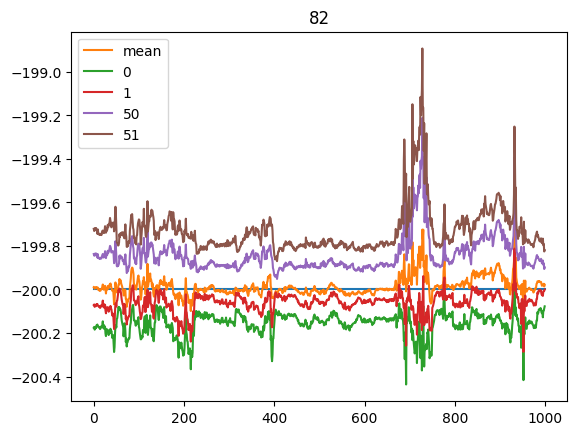

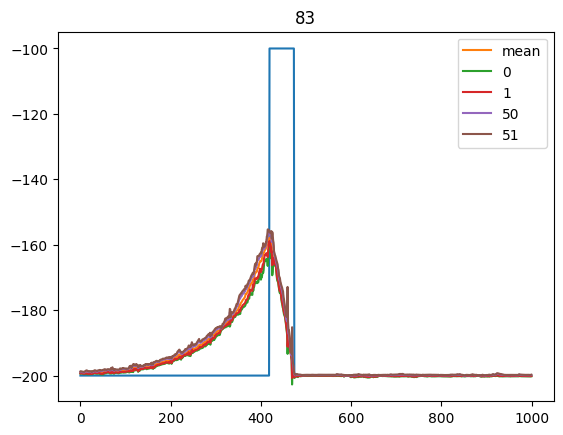

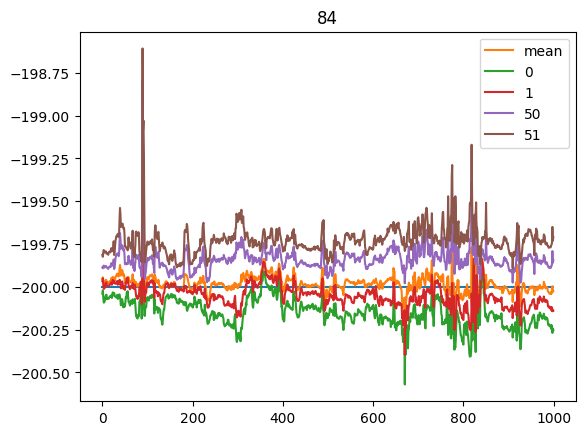

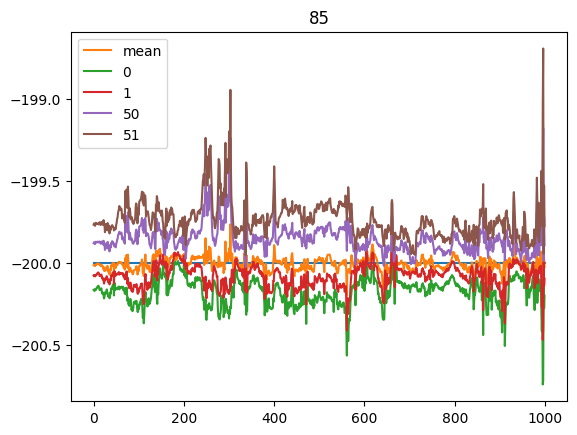

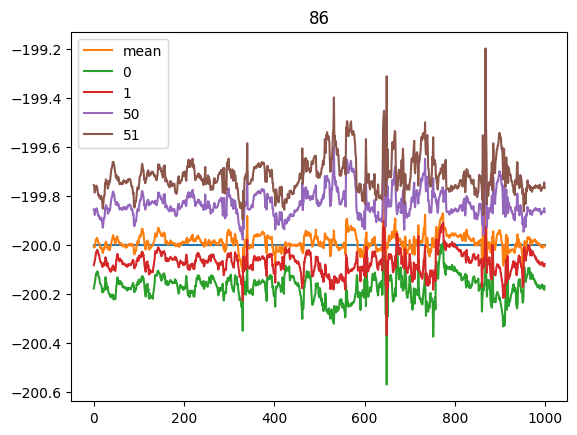

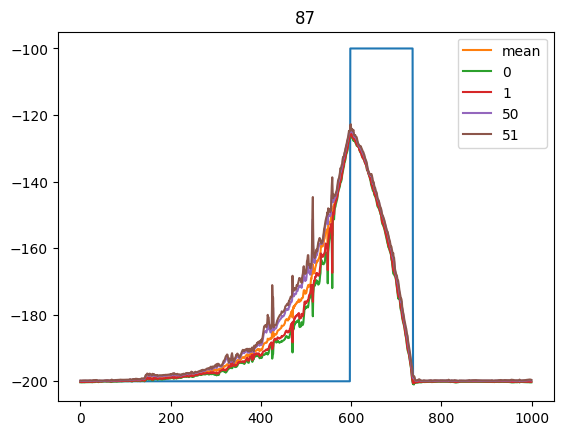

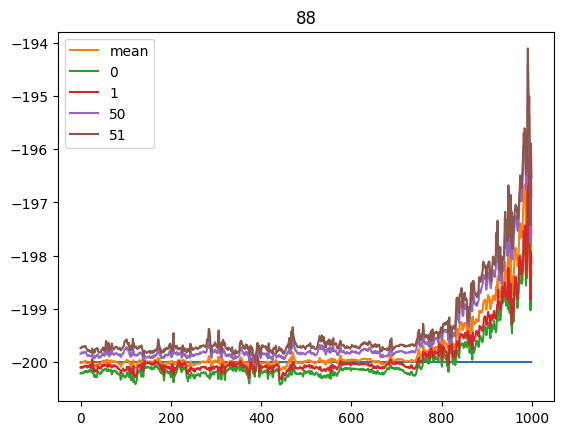

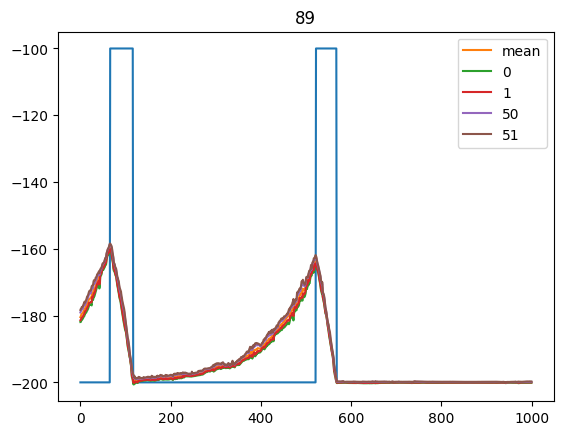

In [ ]:
import matplotlib.pyplot as plt
for i in range(80, 90):
    obs_sample = train_dataset['observations'][i*1000:(i+1)*1000]
    rew_sample = train_dataset['rewards'][i*1000:(i+1)*1000]
    current_zs = agent.network.select('critic')(obs_sample)
    np_zs = np.array(current_zs)

    plt.plot(rew_sample*100)
    # plt.show()
    # plt.ylim([-250, 0])
    plt.title(i)
    plt.plot(np_zs.mean(-1), label='mean')
    plt.plot(np_zs[:, 0], label='0')
    plt.plot(np_zs[:, 1], label='1')
    plt.plot(np_zs[:, -2], label='50')
    plt.plot(np_zs[:, -1], label='51')
    plt.legend()
    plt.show()
    

In [ ]:
np.array(current_zs)

array([[-199.41269, -199.38884, -199.39699, ..., -199.4111 , -199.39836,
        -199.39636],
       [-199.41269, -199.38884, -199.39699, ..., -199.4111 , -199.39836,
        -199.39636],
       [-199.41269, -199.38884, -199.39699, ..., -199.4111 , -199.39836,
        -199.39636],
       ...,
       [-199.41249, -199.3888 , -199.39676, ..., -199.41104, -199.39821,
        -199.3962 ],
       [-199.41249, -199.3888 , -199.39676, ..., -199.41104, -199.39821,
        -199.3962 ],
       [-199.41249, -199.3888 , -199.39676, ..., -199.41104, -199.39821,
        -199.3962 ]], shape=(1000, 51), dtype=float32)

In [ ]:
# @jax.jit
def compute_flow_actions(
    self,
    observations,
    noises,
):
    """
    Compute actions from the BC flow model using Euler method with CFG support.
    
    Logic:
    1. cfg == 1.0: Standard Conditional Generation (g=1).
    2. use_bad_to_good_cfg: Extrapolate from Bad(g=-1) to Good(g=1).
    3. use_cfg: Extrapolate from Uncond(g=None) to Cond(g=1).
    """
    # 1. Encode observations once (Efficiency)
    if self.config['encoder'] is not None:
        observations = self.network.select('actor_bc_flow_encoder')(observations)
        
    actions = noises
    batch_size = actions.shape[0]
    cfg_scale = self.config['cfg']
    
    # Prepare G conditions
    # Positive Target: 1.0
    g_pos = jnp.ones((batch_size, 1), dtype=jnp.float32)
    
    # Negative Target (only for bad_to_good)
    # Negative: -1.0
    g_neg_array = -1.0 * jnp.ones((batch_size, 1), dtype=jnp.float32)

    # Euler loop
    dt = 1.0 / self.config['flow_steps']
    
    def body_fn(i, x):
        t_val = i * dt
        t_batch = jnp.full((batch_size, 1), t_val)
        
        # --- Branching Logic for CFG ---
        
        # Case A: No Guidance (cfg=1.0)
        if cfg_scale == 1.0:
            vel = self.network.select('actor_bc_flow')(
                observations, x, advantage=g_pos, times=t_batch, is_encoded=True
            )
            
        # Case B: Bad-to-Good Guidance (-1 to 1) -> Batch Doubling Optimization
        elif self.config['use_bad_to_good_cfg']:
            # Concatenate inputs to run in a single forward pass
            obs_in = jnp.concatenate([observations, observations], axis=0)
            x_in = jnp.concatenate([x, x], axis=0)
            t_in = jnp.concatenate([t_batch, t_batch], axis=0)
            # Cond: [Positive(1), Negative(-1)]
            g_in = jnp.concatenate([g_pos, g_neg_array], axis=0)
            
            v_out = self.network.select('actor_bc_flow')(
                obs_in, x_in, advantage=g_in, times=t_in, is_encoded=True
            )
            
            v_pos, v_neg = jnp.split(v_out, 2, axis=0)
            vel = v_neg + cfg_scale * (v_pos - v_neg)

        # Case C: Standard CFG (None to 1) -> Two-pass (since None cannot be batched with Array)
        elif self.config['use_cfg']:
            # 1. Conditional (g=1)
            v_pos = self.network.select('actor_bc_flow')(
                observations, x, advantage=g_pos, times=t_batch, is_encoded=True
            )
            # 2. Unconditional (g=None -> Null Embedding)
            v_uncond = self.network.select('actor_bc_flow')(
                observations, x, advantage=None, times=t_batch, is_encoded=True
            )
            
            vel = v_uncond + cfg_scale * (v_pos - v_uncond)
            
        else:
            # Fallback (Should not happen given configs, treat as Case A)
            vel = self.network.select('actor_bc_flow')(
                observations, x, advantage=g_pos, times=t_batch, is_encoded=True
            )

        return x + vel * dt

    # Run Loop
    actions = jax.lax.fori_loop(0, self.config['flow_steps'], body_fn, actions)
    
    # Clip final actions
    actions = jnp.clip(actions, -1.0, 1.0)
    return actions